In [1]:
# kill error when executing argparse in IPython console
import sys; sys.argv=['']; del sys

import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [2]:
!pip install torch
import torch
!pip install torchvision
import torchvision
%matplotlib inline
import matplotlib.pyplot as plt

!pip install seaborn
import seaborn as sns

     |████████████████████████████████| 139.8 MB 9.8 kB/s  eta 0:00:01    |██████▊                         | 29.2 MB 8.0 MB/s eta 0:00:14     |███████████▉                    | 51.5 MB 6.1 MB/s eta 0:00:15     |█████████████████████▎          | 93.0 MB 13.2 MB/s eta 0:00:04     |█████████████████████████▍      | 110.8 MB 13.6 MB/s eta 0:00:03     |█████████████████████████████▎  | 127.9 MB 10.7 MB/s eta 0:00:02     |█████████████████████████████▉  | 130.1 MB 10.7 MB/s eta 0:00:01
     |████████████████████████████████| 1.5 MB 9.5 MB/s eta 0:00:01


In [18]:
import argparse
import random
import copy
import numpy as np
import pandas as pd
import sklearn.metrics as sm
import torch.nn.functional as F

In [4]:
parser = argparse.ArgumentParser(description='Imbalanced MNIST Example')
parser.add_argument('--batch-size', type=int, default=64, metavar='N',
                    help='input batch size for training (default: 64)')
parser.add_argument('--test-batch-size', type=int, default=1000, metavar='N',
                    help='input batch size for testing (default: 1000)')
parser.add_argument('--epochs', type=int, default=100, metavar='N',
                    help='number of epochs to train')
parser.add_argument('--lr', type=float, default=0.01, metavar='LR',
                    help='learning rate (default: 0.01)')
parser.add_argument('--momentum', type=float, default=0.5, metavar='M',
                    help='SGD momentum (default: 0.5)')
parser.add_argument('--no-cuda', action='store_true', default=False,
                    help='disables CUDA training')
parser.add_argument('--seed', type=int, default=42, metavar='S',
                    help='random seed (default: 42)')
args = parser.parse_args()
use_cuda = not args.no_cuda and torch.cuda.is_available()

torch.manual_seed(args.seed)
device = torch.device("cuda" if use_cuda else "cpu")
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}


In [5]:
# load data
test_seq = [
   torchvision.transforms.ToTensor(),
   torchvision.transforms.Normalize((0.1307,), (0.3081,))
]
test_transform = torchvision.transforms.Compose(test_seq)
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.RandomAffine(
        10, shear=10
    )] + test_seq)
train_dataset = torchvision.datasets.MNIST('.', train=True, download=True, transform=train_transform)
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=args.batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('.', train=False, transform=test_transform),
    batch_size=args.test_batch_size, shuffle=True, **kwargs)
test_dataset = torchvision.datasets.MNIST('.', train=False, download=True, transform=test_transform)


In [6]:
print(train_dataset)
print(train_loader)
print(test_loader)

Dataset MNIST
    Number of datapoints: 60000
    Root location: .
    Split: Train
    StandardTransform
Transform: Compose(
               RandomAffine(degrees=[-10.0, 10.0], shear=[-10.0, 10.0])
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
           )


In [7]:
torch.manual_seed(args.seed)
num_classes = 10
classe_labels = range(num_classes)
sample_probs = torch.rand(num_classes)


idx_to_del = [i for i, label in enumerate(train_loader.dataset.targets)               if random.random() > sample_probs[label]]
imbalanced_train_dataset = copy.deepcopy(train_dataset)
imbalanced_train_dataset.targets = np.delete(train_loader.dataset.targets, idx_to_del, axis=0)
imbalanced_train_dataset.data = np.delete(train_loader.dataset.data, idx_to_del, axis=0)
imbalanced_train_loader = torch.utils.data.DataLoader(
    imbalanced_train_dataset, batch_size=args.batch_size, shuffle=True, **kwargs)

Original dataset: 60000 training samples & 10000 testing samples

Distribution of classes in original dataset:


/Users/jessewijlhuizen/opt/anaconda3/lib/python3.9/site-packages/torchvision/datasets/mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


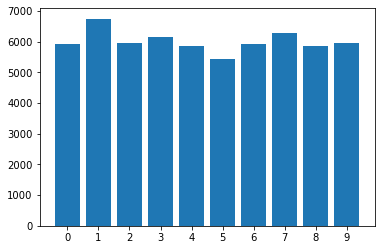

In [8]:
def show_mnist(arr, nrow=5, ncol=10, figsize=None):
    if figsize is None:
        figsize = (ncol, nrow)
        
    f, a = plt.subplots(nrow, ncol, figsize=figsize)
    
    def _do_show(the_figure, the_array):
        the_figure.imshow(the_array)
        the_figure.axis('off')
    
    for i in range(nrow):
        for j in range(ncol):
            _do_show(a[i][j], np.reshape(arr[i * ncol + j], (28, 28)))
            
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.draw()
        
    
def vis(test_accs, confusion_mtxes, labels, figsize=(20, 8)):
    cm = confusion_mtxes[np.argmax(test_accs)]
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%' % p
    cm = pd.DataFrame(cm, index=labels, columns=labels)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    
    fig = plt.figure(figsize=figsize)
    plt.subplot(1, 2, 1)
    plt.plot(test_accs, 'g')
    plt.grid(True)
    
    plt.subplot(1, 2, 2)
    sns.heatmap(cm, annot=annot, fmt='', cmap="Blues")
    plt.show()
        
        
print('Original dataset: %d training samples & %d testing samples\n' % (
    len(train_loader.dataset), len(test_loader.dataset)))
 
print('Distribution of classes in original dataset:')
fig, ax = plt.subplots()
_, counts = np.unique(train_loader.dataset.train_labels, return_counts=True)
ax.bar(classe_labels, counts)
ax.set_xticks(classe_labels)
plt.show()


Sampling probability for each class:


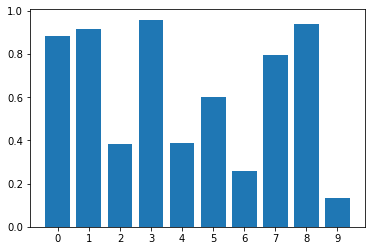

Imbalanced dataset: 37803 training samples & 10000 testing samples

Distribution of classes in imbalanced dataset:


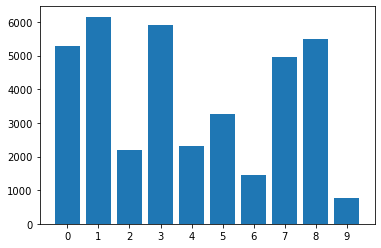

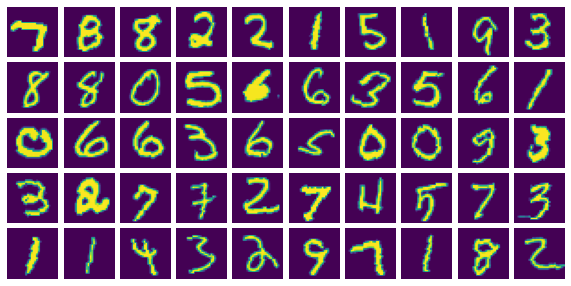

In [9]:

print('Sampling probability for each class:')
fig, ax = plt.subplots()
ax.bar(classe_labels, sample_probs)
ax.set_xticks(classe_labels)
plt.show()
 
print('Imbalanced dataset: %d training samples & %d testing samples\n' % (
    len(imbalanced_train_loader.dataset), len(test_loader.dataset)))

print('Distribution of classes in imbalanced dataset:')
fig, ax = plt.subplots()
_, counts = np.unique(imbalanced_train_loader.dataset.train_labels, return_counts=True)
ax.bar(classe_labels, counts)
ax.set_xticks(classe_labels)
plt.show()

for data, _ in train_loader:
    show_mnist(data)
    break
    

In [19]:
# Calculate the original class proportions
train_labels = np.array(train_dataset.targets)
print(train_labels)
class_counts = np.bincount(train_labels)
print(class_counts)
class_props = class_counts / float(len(train_labels))
print("Class proportions", class_props)
class_prop_sorted = np.sort(class_props)[::-1]
print("class_prop_sorted", class_prop_sorted)
cumulative_prop = np.cumsum(class_prop_sorted)
print("cumulative_prop", cumulative_prop)
# Calculate the Gini coefficient
lorenz_x = np.linspace(0, 1, len(class_prop_sorted))
print("lorenz_x", lorenz_x)
lorenz_y = np.cumsum(class_prop_sorted) / cumulative_prop[-1]
print("lorenz_y", lorenz_y)

# Calculate the area under the Lorenz curve
area_lorenz = np.trapz(lorenz_y, lorenz_x)
print("area_lorenz", area_lorenz)
# Calculate the Gini coefficient
original_gini = ((2 * area_lorenz) - 1)

print("Imbalanced Gini coefficient:", original_gini)


# Calculate the imbalanced class proportions
train_labels = np.array(imbalanced_train_dataset.targets)
class_counts = np.bincount(train_labels)
class_props = class_counts / float(len(train_labels))
print("Class proportions", class_props)
class_prop_sorted = np.sort(class_props)[::-1]

cumulative_prop = np.cumsum(class_prop_sorted)
# Calculate the Gini coefficient
lorenz_x = np.linspace(0, 1, len(class_prop_sorted))
lorenz_y = np.cumsum(class_prop_sorted) / cumulative_prop[-1]
# Calculate the area under the Lorenz curve
area_lorenz = np.trapz(lorenz_y, lorenz_x)

# Calculate the Gini coefficient
imbalanced_gini = ((2 * area_lorenz) - 1)


print("Imbalanced Gini coefficient:", imbalanced_gini)



[5 0 4 ... 5 6 8]
[5923 6742 5958 6131 5842 5421 5918 6265 5851 5949]
Class proportions [0.09871667 0.11236667 0.0993     0.10218333 0.09736667 0.09035
 0.09863333 0.10441667 0.09751667 0.09915   ]
class_prop_sorted [0.11236667 0.10441667 0.10218333 0.0993     0.09915    0.09871667
 0.09863333 0.09751667 0.09736667 0.09035   ]
cumulative_prop [0.11236667 0.21678333 0.31896667 0.41826667 0.51741667 0.61613333
 0.71476667 0.81228333 0.90965    1.        ]
lorenz_x [0.         0.11111111 0.22222222 0.33333333 0.44444444 0.55555556
 0.66666667 0.77777778 0.88888889 1.        ]
lorenz_y [0.11236667 0.21678333 0.31896667 0.41826667 0.51741667 0.61613333
 0.71476667 0.81228333 0.90965    1.        ]
area_lorenz 0.5644944444444445
Imbalanced Gini coefficient: 0.12898888888888904
Class proportions [0.13833205 0.16411332 0.06077583 0.15606829 0.06011205 0.08700847
 0.03828691 0.13020737 0.14568675 0.01940897]
Imbalanced Gini coefficient: 0.40738183953010143


In [155]:
def adjust_classes(class_counts, factor_target, max_adjusted=6):
    # Calculate class proportions
    class_props = class_counts / np.sum(class_counts)
    
    # Sort the class proportions in descending order
    class_prop_sorted = np.sort(class_props)[::-1]
    cumulative_prop = np.cumsum(class_prop_sorted)
    
    # Calculate the area under the Lorenz curve
    area_lorenz = np.trapz(cumulative_prop, x=np.linspace(0, 1, len(class_props)))
    # Calculate the area under the perfect equality line
    area_eq = 0.5
    # Calculate the factor of the original data
    factor = (2 * area_lorenz / cumulative_prop[-1]) - 1
    
    print("factor", factor)
    
    # Check if the target factor is achievable
    if factor > factor_target:
        return None
    
    # Calculate the number of samples to remove from each class
    adjustments = []
    num_adjusted = 0
    for i in range(len(class_props)):
        if class_props[i] == 0:
            continue
        adjusted_prop = class_prop_sorted.copy()
        adjusted_prop[i] = max(class_props[i] - ((factor_target + 1) * cumulative_prop[-1] / (2 * (len(class_props) - num_adjusted) * factor_target)), 0)
        num_samples_adjusted = int(round((class_props[i] - adjusted_prop[i]) * np.sum(class_counts)))
        if num_samples_adjusted > 0:
            num_samples_adjusted = min(num_samples_adjusted, class_counts[i])
            adjustments.append((i, num_samples_adjusted))
            num_adjusted += 1
            if num_adjusted == max_adjusted:
                break
                
    # Check if the target factor is achievable with the given maximum number of adjusted classes
    if num_adjusted < max_adjusted and factor_target > factor:
        return None
    
    return adjustments


In [156]:
# Set the target factor
target_factor = 0.9
class_counts = np.bincount(train_labels)

# Calculate the adjustments
adjustments = adjust_classes(class_counts, target_factor)

# Print the adjustments
if adjustments:
    print(f"Adjustments to reach target factor {target_factor}:")
    for i, num_samples in adjustments:
        print(f"Class {i}: remove {num_samples} samples")
else:
    print(f"Target factor {target_factor} cannot be reached.")

factor 0.28218534994694044
Adjustments to reach target factor 0.9:
Class 0: remove 4599 samples
Class 1: remove 5110 samples
Class 2: remove 2228 samples
Class 3: remove 5875 samples
Class 4: remove 2331 samples
Class 5: remove 3305 samples


In [157]:
adjustments.extend([(6, 0), (7, 0), (8, 0), (9, 0)])
print(adjustments)

[(0, 4599), (1, 5110), (2, 2228), (3, 5875), (4, 2331), (5, 3305), (6, 0), (7, 0), (8, 0), (9, 0)]


In [158]:
def adjust_mnist(train_dataset, test_dataset, adjustments):
    # Convert adjustments to a dictionary for easier lookup
    adjustments_dict = dict(adjustments)

    # Extract the images and labels from the original train dataset
    images = train_dataset.data
    labels = train_dataset.targets

    # Remove samples from each class
    new_images = []
    new_labels = []
    for class_idx in range(10):
        class_mask = (labels == class_idx)
        num_samples_to_remove = adjustments_dict.get(class_idx, 0)
        if num_samples_to_remove > 0:
            if num_samples_to_remove >= torch.sum(class_mask).item():
                # If the number of samples to remove is greater than or equal to the number of samples in the class,
                # just keep the first num_samples_to_remove samples in the class
                keep_indices = torch.arange(torch.sum(class_mask)).long()
            else:
                # Get the indices of the samples to keep
                keep_indices = torch.tensor(np.random.choice(np.where(class_mask)[0], torch.sum(class_mask).item() - num_samples_to_remove, replace=False)).long()

            # Append the remaining samples to the new images and labels
            new_images.append(images[keep_indices])
            new_labels.append(labels[keep_indices])
        else:
            # Append all samples from this class
            new_images.append(images[class_mask])
            new_labels.append(labels[class_mask])

    # Concatenate the new images and labels into tensors
    new_images = torch.cat(new_images, dim=0)
    new_labels = torch.cat(new_labels, dim=0)

    # Create new datasets with the adjusted images and labels
    new_train_dataset = torch.utils.data.TensorDataset(new_images, new_labels)
    new_test_dataset = test_dataset

    return new_train_dataset, new_test_dataset


In [159]:
new_train_dataset, new_test_dataset = adjust_mnist(train_dataset, test_dataset, adjustments)
print(new_train_dataset)

In [160]:
# Calculate the imbalanced class proportions
train_labels = np.array(new_train_dataset.tensors[1])
class_counts = np.bincount(train_labels)
class_props = class_counts / float(len(train_labels))
print("Class proportions", class_props)
class_prop_sorted = np.sort(class_props)[::-1]
cumulative_prop = np.cumsum(class_prop_sorted)
# Calculate the Gini coefficient
lorenz_x = np.linspace(0, 1, len(class_prop_sorted))
lorenz_y = np.cumsum(class_prop_sorted) / cumulative_prop[-1]
# Calculate the area under the Lorenz curve
area_lorenz = np.trapz(lorenz_y, lorenz_x)    
# Calculate the Gini coefficient
imbalanced_gini = ((2 * area_lorenz) - 1)


print("Imbalanced Gini coefficient:", imbalanced_gini)

Class proportions [0.03622237 0.04464872 0.1020464  0.00700372 0.09605494 0.05789013
 0.16190633 0.17139965 0.16007332 0.16275443]
Imbalanced Gini coefficient: 0.4547463583084068


In [4]:
i = [0.2, 0.2, 0.2, 0.2, 0.2]
b = [0.2, 0.4, 0.6, 0.8, 1]
n = 5

for j in range(n):
    print(i[j] * b[j])
    print(j)
    
result = 2 * sum([i[j] * b[j] for j in range(n)])

print(result)



0.04000000000000001
0
0.08000000000000002
1
0.12
2
0.16000000000000003
3
0.2
4
1.2000000000000002


In [11]:
f = [0.2, 0.2, 0.2, 0.2, 0.2]
m = 5
i = [1, 2, 3, 4, 5]

for j in range(m):
    print((i[j]/m) * f[j])
    print(j)


result = sum([(i[j]/m) * f[j] for j in range(m)])
print(result)


0.04000000000000001
0
0.08000000000000002
1
0.12
2
0.16000000000000003
3
0.2
4
0.6000000000000001


In [79]:
def gini(x):
        total = 0
        for i, xi in enumerate(x[:-1], 1):
            total += np.sum(np.abs(xi - x[i:]))
        return total / (len(x)**2 * np.mean(x))

In [127]:
x = np.array([2.24609375, 1, 1, 1, 1, 1, 1, 1, 1, 1])
gini(x)

0.09972212573810352

In [136]:
def find_relative_distribution_given_targetgini(target_gini, n): #target_gini is the gini to be reached with the eventual distribution, n is the number of categories in the eventual distribution 
    # Define the gini function
    def gini(x):
        total = 0
        for i, xi in enumerate(x[:-1], 1):
            total += np.sum(np.abs(xi - x[i:]))
        return total / (len(x)**2 * np.mean(x))

    # Set the initial lower and upper bounds for the first element
    lower_bound = 0
    upper_bound = 100

    # Use binary search to find the appropriate value for the first element
    while True:
        mid = (lower_bound + upper_bound) / 2
        x = np.array([mid] + [1]*(n-1))
        g = gini(x)
        
        if abs(g - target_gini) < 1e-3:
            r = x / np.sum(x)
            print("Relative distribution over n categories:", r)
            g = gini(r)
            print("Gini coefficient:", g)
            return g, r
            
        elif g > target_gini:
            upper_bound = mid
        else:
            lower_bound = mid

In [137]:
target_gini = 0.5
n = 10 
g, r = find_relative_distribution_given_targetgini(target_gini, n)

Relative distribution over n categories: [0.5995829  0.04449079 0.04449079 0.04449079 0.04449079 0.04449079
 0.04449079 0.04449079 0.04449079 0.04449079]
Gini coefficient: 0.49958289885297197
